In [1]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [6]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [7]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [8]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
#     assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    assert method in ['not', 
                      'over', 
                      'under', 
                      'tomek', 
                      'smote', 
                      'over_under', 
                      'tomek_smote', 
                      'tomek_over'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Пути к директориям и файлам**

In [9]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [11]:
train_df.shape

(7500, 17)

In [12]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [13]:
test_df.shape

(2500, 16)

# ТЕКУЩИЕ ВОЗМОЖНОСТИ

#### задание имени целевой переменной

In [14]:
TARGET_NAME = 'Credit Default'

#### функции предобработки данных

In [15]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

In [16]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

In [17]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

In [18]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

In [19]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

In [20]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

In [21]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

In [22]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
    return X

In [23]:
def generate_G_annual_income_was_nan(X):
    X['G_annual_income_was_nan'] = 0
    X.loc[X['Annual Income'].isna(), 'G_annual_income_was_nan'] = 1  
    return X

In [24]:
def generate_target_encoded_feature_for_a_numerical_feature(df, number_of_categories, 
                                                            feature_name, target_name, 
                                                            push_right_min_outliers_in_feature_name, 
                                                            push_left_max_outliers_in_feature_name):
    # функция генерирует новый признак
    # путём разбиения пространства оригинального признака на заданное количество равных интервалов
    # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
    # к общему числу объектов на каждом интервале
    # с присвоением значения вероятности какждому объекту в виде значения нового признака.
    # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
    # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
    # при генерации нового признака используя действительную функцию
    # следует проверить целесообразность такого действия 
    # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
    # значений равных 2.5% от минимума и 2.5% от максимума соответственно
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers_in_feature_name:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers_in_feature_name:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
    
    # выявление минимального и максимального значений на пространстве значений исходного признака
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    # создание интервалов из пространства значений исходного признака
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    # генерация имени нового признака
    new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'
    
    # заполнение нового признака средним значением целевой переменной -
    # перестраховка, чтобы избежать возможности пропусков
    X[new_feature_name] = X[target_name].mean()
    
    # заполнение пропусков в признаке средним значением целевой переменной на объектах,
    # где есть пропуски в признаках
    X.loc[X[feature_name].isna(), new_feature_name] = X.loc[X[feature_name].isna(), target_name].mean()
    
    # присвоение каждому объекту значения нового признака равного вероятности 
    # появления значения целевой переменной == 1 на заданном интервале оригинального признака
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(X[feature_name] >= limits_of_categories[i]) & 
                      (X[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
            
            X.loc[(X[feature_name] >= limits_of_categories[i]) & 
                  (X[feature_name] < limits_of_categories[i + 1]), 
                  new_feature_name] = round((category_stat[1] / sum(category_stat)), 3) 
            
        except:
            None

        i += 1
        
    return X

#### создание обучающего датафрейма

In [25]:
df = train_df.copy()

#### размер датафрейма

In [26]:
df.shape

(7500, 17)

#### количество пропусков в обучающем датафрейме

In [27]:
df.isna().sum().sum()

7580

#### активация функций предобработки данных

In [28]:
df = generate_dummies_from_home_ownership(df)
df = generate_G_home_ownership_reduced_to_binary(df)
df = generate_G_years_in_current_job_reduced_to_binary(df)
df = generate_G_purpose_reduced_to_binary(df)
df = generate_G_term_transformed_to_binary(df)
df = generate_G_tax_liens_reduced_to_binary(df)
df = generate_G_number_of_credit_problems_reduced_to_binary(df)
df = generate_G_bankruptcies_reduced_to_binary(df)
# df = generate_G_annual_income_was_nan(df)  # можно убрать эту функцию
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Annual Income',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Current Loan Amount',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Maximum Open Credit',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=5, 
                                                             feature_name='Number of Open Accounts',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Years of Credit History',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Monthly Debt',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Months since last delinquent',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Credit Score',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=False)

In [29]:
df.shape

(7500, 37)

#### создание списков индексов объектов с однозначно идентифицированной целевой переменной

In [30]:
indexes_of_df_with_target_0 = df[df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index.to_list()
indexes_of_df_with_target_1 = df[df['Credit Score'] > 1000]['Credit Score'].index.to_list()

In [31]:
len(indexes_of_df_with_target_0), len(indexes_of_df_with_target_1)

(870, 400)

#### заполнение пропусков в Credit Score и Annual Income наиболее подходящими значениями в разрезе целевой переменной

In [32]:
df['Credit Score'].isna().sum(), df['Annual Income'].isna().sum()

(1557, 1557)

In [33]:
# df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())
# df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())

df['Credit Score'] = df['Credit Score'].fillna(680.1)
df['Annual Income'] = df['Annual Income'].fillna(300000.1)

In [34]:
df['Credit Score'].isna().sum(), df['Annual Income'].isna().sum()

(0, 0)

#### обрезка ненужных признаков

In [35]:
list_of_columns_to_drop = ['Home Ownership', 
#                            'Annual Income', 
                           'Years in current job', 
                           'Tax Liens',
                           'Number of Open Accounts', 
                           'Years of Credit History',
                           'Maximum Open Credit', 
                           'Number of Credit Problems',
                           'Months since last delinquent', 
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           'Current Loan Amount', 
                           'Current Credit Balance', 
                           'Monthly Debt', 
#                            'Credit Score'
                          ]

In [36]:
df = df.drop(list_of_columns_to_drop, axis=1)

In [37]:
df.isna().sum().sum()

0

In [38]:
df.dtypes

Annual Income                                    float64
Credit Score                                     float64
Credit Default                                     int64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_en

#### разбиение на train и test

In [39]:
TARGET_NAME = 'Credit Default'

X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=99,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### отрезка однозначно идентифицированных объектов

In [40]:
# train
X_train_reduced = X_train.drop(X_train[X_train.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

y_train_reduced = y_train.drop(y_train[y_train.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)


# test
X_valid_reduced = X_valid.drop(X_valid[X_valid.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

y_valid_reduced = y_valid.drop(y_valid[y_valid.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

In [41]:
X_train_reduced.shape, y_train_reduced.shape

((4347, 22), (4347,))

In [42]:
X_valid_reduced.shape, y_valid_reduced.shape

((1883, 22), (1883,))

## Подбор модели

In [43]:
NUM_FEATURE_NAMES = [i for i in X_valid_reduced.dtypes.index if X_valid_reduced[i].dtype == 'float64']
NUM_FEATURE_NAMES

# NUM_FEATURE_NAMES = ['Annual Income', 
#                      'Credit Score', 
#                      'G_annual_income_target_encoded', 
#                      'G_current_loan_amount_target_encoded', 
#                      'G_maximum_open_credit_target_encoded', 
#                      'G_number_of_open_accounts_target_encoded', 
#                      'G_years_of_credit_history_target_encoded', 
#                      'G_monthly_debt_target_encoded', 
#                      'G_months_since_last_delinquent_target_encoded', 
#                      'G_credit_score_target_encoded']

['Annual Income',
 'Credit Score',
 'G_annual_income_target_encoded',
 'G_current_loan_amount_target_encoded',
 'G_maximum_open_credit_target_encoded',
 'G_number_of_open_accounts_target_encoded',
 'G_years_of_credit_history_target_encoded',
 'G_monthly_debt_target_encoded',
 'G_months_since_last_delinquent_target_encoded',
 'G_credit_score_target_encoded']

#### масштабирование данных

In [44]:
scaler = StandardScaler()

X_train_reduced[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_reduced[NUM_FEATURE_NAMES])
X_valid_reduced[NUM_FEATURE_NAMES] = scaler.transform(X_valid_reduced[NUM_FEATURE_NAMES])

In [45]:
X_train_reduced = reduce_mem_usage(X_train_reduced)
X_valid_reduced = reduce_mem_usage(X_valid_reduced)

Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.25 MB
Decreased by 67.4%
Memory usage of dataframe is 0.33 MB
Memory usage after optimization is: 0.11 MB
Decreased by 67.4%


## Подбор базовой модели обучения с параметрами по-умолчанию, перебор вариантов балансировки классов

#### Ничего не делаем с данными

In [46]:
df_ = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'
    
df_[TARGET_NAME].value_counts()

0    3140
1    1207
Name: Credit Default, dtype: int64

In [47]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train_reduced, 
                                                         X_valid_reduced, 
                                                         y_train_reduced, 
                                                         y_valid_reduced, 
                                                         method='not')
stata_not_balanced

[17:37:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.55 s


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.848331,0.839568,0.231884,0.215447,0.540107,0.527507,lr
1,0.810236,0.856513,0.245707,0.484144,0.527971,0.670328,knn
2,0.741853,0.988807,0.318841,0.969800,0.530347,0.979303,tree
3,0.821549,0.929785,0.334171,0.771415,0.577860,0.850600,xgb
4,0.837255,0.887027,0.294618,0.558691,0.565936,0.722859,lgbm
5,0.843093,0.881419,0.281481,0.513212,0.562287,0.697315,cat


#### Oversampling

In [48]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3140
1    2414
Name: Credit Default, dtype: int64

In [49]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [50]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, 
                                                  X_valid_reduced, 
                                                  y_train_balanced, 
                                                  y_valid_reduced, 
                                                  method='over')
stata_balanced_over

[17:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 10.8 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.785845,0.713158,0.427317,0.517033,0.606581,0.615096,lr
1,0.738156,0.791222,0.316395,0.698636,0.527276,0.744929,knn
2,0.754135,0.985438,0.359809,0.981272,0.556972,0.983355,tree
3,0.778020,0.910863,0.400786,0.880556,0.589403,0.895710,xgb
4,0.775856,0.844282,0.419447,0.774051,0.597651,0.809167,lgbm
5,0.794413,0.838049,0.410678,0.758961,0.602545,0.798505,cat


#### Undersampling

In [51]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    1207
1    1207
Name: Credit Default, dtype: int64

In [52]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [53]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, 
                                                    X_valid_reduced, 
                                                    y_train_balanced, 
                                                    y_valid_reduced, 
                                                    method='under')
stata_balanced_under

[17:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.28 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.699417,0.619932,0.470674,0.634146,0.585046,0.627039,lr
1,0.656419,0.750603,0.391464,0.735269,0.523942,0.742936,knn
2,0.614248,0.989309,0.393443,0.989149,0.503846,0.989229,tree
3,0.628947,0.935108,0.430686,0.935644,0.529817,0.935376,xgb
4,0.632224,0.878069,0.433198,0.879175,0.532711,0.878622,lgbm
5,0.668662,0.822352,0.456903,0.824691,0.562782,0.823522,cat


#### Undersampling (Tomeklinks)

In [54]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    2753
1    1207
Name: Credit Default, dtype: int64

In [55]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, 
                                                    X_valid_reduced, 
                                                    y_train_balanced, 
                                                    y_valid_reduced, 
                                                    method='tomek')
stata_balanced_tomek

[17:37:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.84 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.841348,0.820439,0.315938,0.311355,0.578643,0.565897,lr
1,0.783989,0.854684,0.278802,0.568421,0.531395,0.711552,knn
2,0.722348,0.987251,0.333935,0.969800,0.528141,0.978525,tree
3,0.811275,0.928866,0.359393,0.802857,0.585334,0.865862,xgb
4,0.825546,0.888889,0.343869,0.647709,0.584707,0.768299,lgbm
5,0.827426,0.876022,0.302544,0.580288,0.564985,0.728155,cat


#### Oversampling (SMOTE)

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    3140
1    3140
Name: Credit Default, dtype: int64

In [57]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, 
                                                    X_valid_reduced, 
                                                    y_train_balanced, 
                                                    y_valid_reduced, 
                                                    method='smote')
stata_balanced_smote

[17:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.96 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.692018,0.612704,0.463219,0.629595,0.577619,0.621149,lr
1,0.664763,0.792745,0.374429,0.828949,0.519596,0.810847,knn
2,0.738496,0.987670,0.360476,0.987488,0.549486,0.987579,tree
3,0.811308,0.920386,0.332530,0.910931,0.571919,0.915659,xgb
4,0.817073,0.881086,0.336609,0.860602,0.576841,0.870844,lgbm
5,0.829398,0.873379,0.324111,0.847464,0.576754,0.860421,cat


#### OVERSAMPLING + UNDERSAMPLING

In [58]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced = balance_df_by_target(df_balanced, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    2414
1    2414
Name: Credit Default, dtype: int64

In [59]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [60]:
%%time
stata_balanced_over_under, models_over_under = run_experiment(X_train_balanced, 
                                                              X_valid_reduced, 
                                                              y_train_balanced, 
                                                              y_valid_reduced, 
                                                              method='over_under')
stata_balanced_over_under

[17:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.69 s


,f1_0_test_over_under,f1_0_train_over_under,f1_1_test_over_under,f1_1_train_over_under,f1_macro_test_over_under,f1_macro_train_over_under,model_name
0,0.707046,0.640378,0.469007,0.634218,0.588026,0.637298,lr
1,0.688266,0.774682,0.361134,0.755613,0.524700,0.765147,knn
2,0.692185,0.984285,0.386328,0.984232,0.539256,0.984258,tree
3,0.691368,0.918715,0.421374,0.920940,0.556371,0.919827,xgb
4,0.701596,0.852108,0.448980,0.855799,0.575288,0.853953,lgbm
5,0.705306,0.843566,0.451368,0.848163,0.578337,0.845865,cat


#### TOMEKLINKS + SMOTE

In [61]:
tl = TomekLinks()
smote = SMOTE()

X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_balanced)

y_train_balanced.value_counts()

0    2753
1    2753
Name: Credit Default, dtype: int64

In [62]:
%%time
stata_balanced_tomek_smote, models_tomek_smote = run_experiment(X_train_balanced, 
                                                                X_valid_reduced, 
                                                                y_train_balanced, 
                                                                y_valid_reduced, 
                                                                method='tomek_smote')
stata_balanced_tomek_smote

[17:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.14 s


,f1_0_test_tomek_smote,f1_0_train_tomek_smote,f1_1_test_tomek_smote,f1_1_train_tomek_smote,f1_macro_test_tomek_smote,f1_macro_train_tomek_smote,model_name
0,0.693177,0.628898,0.467683,0.640443,0.580430,0.634671,lr
1,0.655927,0.813420,0.380669,0.839222,0.518298,0.826321,knn
2,0.719847,0.986316,0.359511,0.986075,0.539679,0.986196,tree
3,0.809557,0.921791,0.410870,0.914817,0.610213,0.918304,xgb
4,0.805304,0.883450,0.380000,0.868253,0.592652,0.875852,lgbm
5,0.809605,0.871207,0.347826,0.849606,0.578716,0.860407,cat


#### TOMEKLINKS + OVERSAMPLING

In [63]:
tl = TomekLinks()

X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)
df_for_balancing = pd.concat([X_train_balanced, y_train_balanced], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
# df_balanced = balance_df_by_target(df_balanced, TARGET_NAME, method='under')  # !!!

df_balanced[TARGET_NAME].value_counts()

0    2753
1    2414
Name: Credit Default, dtype: int64

In [64]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [65]:
%%time
stata_balanced_tomek_over, models_tomek_over = run_experiment(X_train_balanced, 
                                                              X_valid_reduced, 
                                                              y_train_balanced, 
                                                              y_valid_reduced, 
                                                              method='tomek_over')
stata_balanced_tomek_over

[17:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.27 s


,f1_0_test_tomek_over,f1_0_train_tomek_over,f1_1_test_tomek_over,f1_1_train_tomek_over,f1_macro_test_tomek_over,f1_macro_train_tomek_over,model_name
0,0.754482,0.678359,0.475000,0.576552,0.614741,0.627455,lr
1,0.712582,0.798665,0.359897,0.753124,0.536239,0.775894,knn
2,0.723147,0.983379,0.347594,0.981272,0.535370,0.982325,tree
3,0.747436,0.916803,0.413063,0.905598,0.580250,0.911201,xgb
4,0.751908,0.849379,0.432810,0.824785,0.592359,0.837082,lgbm
5,0.759379,0.833777,0.436557,0.800511,0.597968,0.817144,cat


#### Сводим результаты вместе

In [66]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name') \
                                   .merge(stata_balanced_over_under, on='model_name') \
                                   .merge(stata_balanced_tomek_smote, on='model_name') \
                                   .merge(stata_balanced_tomek_over, on='model_name') 





stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek_smote,f1_1_train_tomek_smote,f1_macro_test_tomek_smote,f1_macro_train_tomek_smote,f1_0_test_tomek_over,f1_0_train_tomek_over,f1_1_test_tomek_over,f1_1_train_tomek_over,f1_macro_test_tomek_over,f1_macro_train_tomek_over
0,0.848331,0.839568,0.231884,0.215447,0.540107,0.527507,lr,0.699417,0.619932,0.470674,...,0.467683,0.640443,0.580430,0.634671,0.754482,0.678359,0.475000,0.576552,0.614741,0.627455
1,0.810236,0.856513,0.245707,0.484144,0.527971,0.670328,knn,0.656419,0.750603,0.391464,...,0.380669,0.839222,0.518298,0.826321,0.712582,0.798665,0.359897,0.753124,0.536239,0.775894
2,0.741853,0.988807,0.318841,0.969800,0.530347,0.979303,tree,0.614248,0.989309,0.393443,...,0.359511,0.986075,0.539679,0.986196,0.723147,0.983379,0.347594,0.981272,0.535370,0.982325
3,0.821549,0.929785,0.334171,0.771415,0.577860,0.850600,xgb,0.628947,0.935108,0.430686,...,0.410870,0.914817,0.610213,0.918304,0.747436,0.916803,0.413063,0.905598,0.580250,0.911201
4,0.837255,0.887027,0.294618,0.558691,0.565936,0.722859,lgbm,0.632224,0.878069,0.433198,...,0.380000,0.868253,0.592652,0.875852,0.751908,0.849379,0.432810,0.824785,0.592359,0.837082


In [67]:
stata_combined.describe()[
    [
#         'f1_macro_test_not', 
#         'f1_macro_test_under', 
#         'f1_macro_test_over',
#         'f1_macro_test_tomek', 
#         'f1_macro_test_smote', 
#         'f1_macro_test_over_under',
#         'f1_macro_test_tomek_smote', 
#         'f1_macro_test_tomek_over',
        'f1_1_test_not', 
        'f1_1_test_under', 
        'f1_1_test_over',
        'f1_1_test_tomek', 
        'f1_1_test_smote', 
        'f1_1_test_over_under', 
        'f1_1_test_tomek_smote', 
        'f1_1_test_tomek_over'
    ]
]

,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote,f1_1_test_over_under,f1_1_test_tomek_smote,f1_1_test_tomek_over
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.284450,0.429395,0.389072,0.322413,0.365229,0.423032,0.391093,0.410820
std,0.040078,0.032274,0.042726,0.029323,0.051553,0.041884,0.043263,0.048705
min,0.231884,0.391464,0.316395,0.278802,0.324111,0.361134,0.347826,0.347594
25%,0.254650,0.402754,0.370053,0.305892,0.333550,0.395089,0.364634,0.373189
50%,0.288050,0.431942,0.405732,0.324936,0.348543,0.435177,0.380335,0.422936
75%,0.312785,0.450977,0.417255,0.341385,0.370941,0.450771,0.403319,0.435620
max,0.334171,0.470674,0.427317,0.359393,0.463219,0.469007,0.467683,0.475000


In [68]:
stata_combined.sort_values('f1_1_test_tomek_smote', ascending=False).iloc[0]

f1_0_test_not                 0.848331
f1_0_train_not                0.839568
f1_1_test_not                 0.231884
f1_1_train_not                0.215447
f1_macro_test_not             0.540107
f1_macro_train_not            0.527507
model_name                          lr
f1_0_test_under               0.699417
f1_0_train_under              0.619932
f1_1_test_under               0.470674
f1_1_train_under              0.634146
f1_macro_test_under           0.585046
f1_macro_train_under          0.627039
f1_0_test_over                0.785845
f1_0_train_over               0.713158
f1_1_test_over                0.427317
f1_1_train_over               0.517033
f1_macro_test_over            0.606581
f1_macro_train_over           0.615096
f1_0_test_tomek               0.841348
f1_0_train_tomek              0.820439
f1_1_test_tomek               0.315938
f1_1_train_tomek              0.311355
f1_macro_test_tomek           0.578643
f1_macro_train_tomek          0.565897
f1_0_test_smote          

#### подсчёт метрики на урезанных train и valid (без однозначно идентифицированных объектов)

#### при предсказании используем модель LogisticRegression обученную на урезанных данных train датасета (без однозначно идентифицированных объектов) и сбалансированных по классам при помощи комбинации из TomekLinks и SMOTE подходов

In [69]:
model = models_tomek_smote['lr']

In [70]:
y_train_pred_reduced = model.predict(X_train_reduced)
y_valid_pred_reduced = model.predict(X_valid_reduced)

In [71]:
get_classification_report(y_train_reduced, y_train_pred_reduced, y_valid_reduced, y_valid_pred_reduced)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      3140
           1       0.38      0.65      0.48      1207

    accuracy                           0.61      4347
   macro avg       0.60      0.63      0.59      4347
weighted avg       0.70      0.61      0.63      4347

TEST

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      1377
           1       0.37      0.64      0.47       506

    accuracy                           0.61      1883
   macro avg       0.59      0.62      0.58      1883
weighted avg       0.70      0.61      0.63      1883

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828  549
1               184  322


#### подсчёт метрики на train и valid (с однозначно идентифицированными объектами)

In [72]:
y_train_pred = y_train.copy()
y_valid_pred = y_valid.copy()

y_train_pred[:] = np.nan
y_valid_pred[:] = np.nan

y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

y_valid_pred.loc[y_valid_reduced.index] = y_valid_pred_reduced
y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

y_train_pred = np.array(y_train_pred)
y_valid_pred = np.array(y_valid_pred)

In [73]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      3771
           1       0.46      0.72      0.56      1479

    accuracy                           0.68      5250
   macro avg       0.66      0.69      0.65      5250
weighted avg       0.74      0.68      0.69      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1616
           1       0.45      0.71      0.55       634

    accuracy                           0.67      2250
   macro avg       0.65      0.69      0.65      2250
weighted avg       0.74      0.67      0.69      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1067  549
1                184  450


## Выбор порога вероятности для определения класса для балансировки precision и recall

In [74]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


In [75]:
y_valid_reduced_pred_probs = model.predict_proba(X_valid_reduced)
y_valid_reduced_pred_probs

array([[0.58337391, 0.41662609],
       [0.49751587, 0.50248413],
       [0.69510391, 0.30489609],
       ...,
       [0.55141088, 0.44858912],
       [0.55202402, 0.44797598],
       [0.32781286, 0.67218714]])

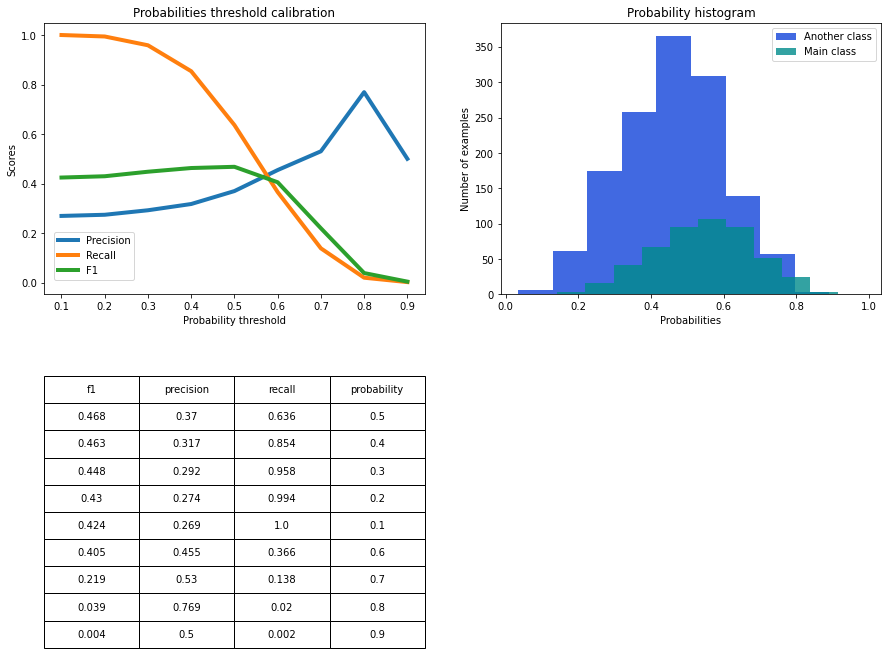

In [76]:
show_proba_calibration_plots(y_valid_reduced_pred_probs[:, 1], y_valid_reduced)

In [77]:
y_train_pred_reduced = model.predict_proba(X_train_reduced)
y_valid_pred_reduced = model.predict_proba(X_valid_reduced)

In [78]:
def classify_results_by_probability(array_of_results_in_probability, probability_threshold):
    list_of_results_in_1_and_0 = []
    for i in array_of_results_in_probability:
        if i[1] <= probability_threshold:
            list_of_results_in_1_and_0.append(0)
        elif i[1] > probability_threshold:
            list_of_results_in_1_and_0.append(1)
    return list_of_results_in_1_and_0

In [79]:
probability_threshold = 0.575

y_train_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_train_pred_reduced,
                                                       probability_threshold=probability_threshold)

y_valid_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_valid_pred_reduced,
                                                      probability_threshold=probability_threshold)

In [80]:
y_train_pred = y_train.copy()
y_valid_pred = y_valid.copy()

y_train_pred[:] = np.nan
y_valid_pred[:] = np.nan

y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

y_valid_pred.loc[y_valid_reduced.index] = y_valid_pred_reduced
y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

y_train_pred = np.array(y_train_pred)
y_valid_pred = np.array(y_valid_pred)

In [81]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.54      0.52      0.53      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.67      0.67      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.55      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1318  298
1                288  346


#### Как видно, модель уверенно классифицирует объекты в рамках параметров указанных в задании к курсовому проекту. Переобучения не наблюдается.

#### напишем удобную функцию по подсчёту метрик

In [82]:
def check_metrics(model, probability_threshold, list_of_features):

    y_train_pred_reduced = model.predict_proba(X_train_reduced[list_of_features])
    y_valid_pred_reduced = model.predict_proba(X_valid_reduced[list_of_features])

    def classify_results_by_probability(array_of_results_in_probability, probability_threshold):
        list_of_results_in_1_and_0 = []
        for i in array_of_results_in_probability:
            if i[1] <= probability_threshold:
                list_of_results_in_1_and_0.append(0)
            elif i[1] > probability_threshold:
                list_of_results_in_1_and_0.append(1)
        return list_of_results_in_1_and_0

    y_train_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_train_pred_reduced,
                                                           probability_threshold=probability_threshold)

    y_valid_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_valid_pred_reduced,
                                                          probability_threshold=probability_threshold)

    y_train_pred = y_train.copy()
    y_valid_pred = y_valid.copy()

    y_train_pred[:] = np.nan
    y_valid_pred[:] = np.nan

    y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
    y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
    y_train_pred.loc[y_train_pred[y_train_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

    y_valid_pred.loc[y_valid_reduced.index] = y_valid_pred_reduced
    y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_0)].index] = 0
    y_valid_pred.loc[y_valid_pred[y_valid_pred.index.isin(indexes_of_df_with_target_1)].index] = 1

    y_train_pred = np.array(y_train_pred)
    y_valid_pred = np.array(y_valid_pred)

    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

#### проверим работоспособность функции

In [83]:
check_metrics(model=model, probability_threshold=0.575, list_of_features=X_train_reduced.columns)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.54      0.52      0.53      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.67      0.67      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.55      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1318  298
1                288  346


всё работает

## Попробуем улучшить модель при помощи кросс-валидации и подбора гиперпараметров

#### объединим урезанные train и valid датасеты (без однозначно идентифицированных объектов) в один датасет

In [84]:
X_train_reduced.shape, X_valid_reduced.shape, y_train_reduced.shape, y_valid_reduced.shape

((4347, 22), (1883, 22), (4347,), (1883,))

In [85]:
X_reduced = pd.concat([X_train_reduced, X_valid_reduced], axis=0)
y_reduced = pd.concat([y_train_reduced, y_valid_reduced], axis=0)

X_reduced.shape, y_reduced.shape

((6230, 22), (6230,))

In [86]:
y_reduced.value_counts()

0    4517
1    1713
Name: Credit Default, dtype: int64

#### сбалансируем датасет при помощи уже ранее использованной комбинации из TomekLinks и SMOTE

In [87]:
tl = TomekLinks()
smote = SMOTE()

X_balanced, y_balanced = tl.fit_resample(X_reduced, y_reduced)
X_balanced, y_balanced = smote.fit_resample(X_train_balanced, y_train_balanced)

y_balanced.value_counts()

0    2753
1    2753
Name: Credit Default, dtype: int64

#### проведём кросс-валидацию модели на 3х фолдах с перебором гиперпараметров

In [88]:
logModel = LogisticRegression()

param_grid = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-2, 2, 20),
     'solver': ['lgfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
     'max_iter': [100, 500, 1000]
    }
]

clf = GridSearchCV(logModel, 
                   param_grid=param_grid, 
                   cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
                   verbose=True, 
#                    n_jobs=-1
                  )

In [89]:
list_of_features = ['Annual Income',
                     'Credit Score',
                     'G_home_ownership_home_mortgage',
                     'G_home_ownership_rent',
                     'G_home_ownership_own_home',
                     'G_home_ownership_have_mortgage',
                     'G_home_ownership_other',
                     'G_home_ownership_reduced_to_binary',
                     'G_years_in_current_job_reduced_to_binary',
                     'G_purpose_reduced_to_binary',
                     'G_term_transformed_to_binary',
                     'G_tax_liens_reduced_to_binary',
                     'G_number_of_credit_problems_reduced_to_binary',
                     'G_bankruptcies_reduced_to_binary',
                     'G_annual_income_target_encoded',
                     'G_current_loan_amount_target_encoded',
                     'G_maximum_open_credit_target_encoded',
                     'G_number_of_open_accounts_target_encoded',
                     'G_years_of_credit_history_target_encoded',
                     'G_monthly_debt_target_encoded',
                     'G_months_since_last_delinquent_target_encoded',
                     'G_credit_score_target_encoded']

In [90]:
%%time

# best_clf = clf.fit(X_reduced, y_reduced)
best_clf = clf.fit(X_balanced[list_of_features], y_balanced)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Wall time: 7min 12s


In [91]:
best_clf.best_estimator_

LogisticRegression(C=0.016237767391887217, solver='newton-cg')

In [92]:
best_clf.score(X_balanced[list_of_features], y_balanced)

0.6345804576825281

In [93]:
model = best_clf.best_estimator_

# model.fit(X_balanced[list_of_features], y_balanced)
model.fit(X_train_balanced[list_of_features], y_train_balanced)

check_metrics(model=model, probability_threshold=0.54, list_of_features=list_of_features)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3771
           1       0.55      0.53      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.54      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1328  288
1                290  344


#### визуализируем какой вклад вносит каждый из коэффициентов, которые подобрала наша модель на этапе обучения

In [94]:
features_coefficients = pd.Series(model.coef_.tolist()[0], index=X_reduced[list_of_features].columns.tolist())
features_coefficients = abs(features_coefficients).sort_values()
print(features_coefficients)

G_current_loan_amount_target_encoded             0.000000
G_home_ownership_other                           0.000000
G_home_ownership_own_home                        0.020778
G_home_ownership_have_mortgage                   0.022066
G_years_of_credit_history_target_encoded         0.042367
G_home_ownership_home_mortgage                   0.090001
G_tax_liens_reduced_to_binary                    0.092505
G_number_of_open_accounts_target_encoded         0.093859
G_months_since_last_delinquent_target_encoded    0.096838
G_home_ownership_reduced_to_binary               0.112066
G_purpose_reduced_to_binary                      0.123860
G_home_ownership_rent                            0.132842
G_number_of_credit_problems_reduced_to_binary    0.138687
G_bankruptcies_reduced_to_binary                 0.138687
G_maximum_open_credit_target_encoded             0.165060
G_credit_score_target_encoded                    0.166293
G_annual_income_target_encoded                   0.176856
G_monthly_debt

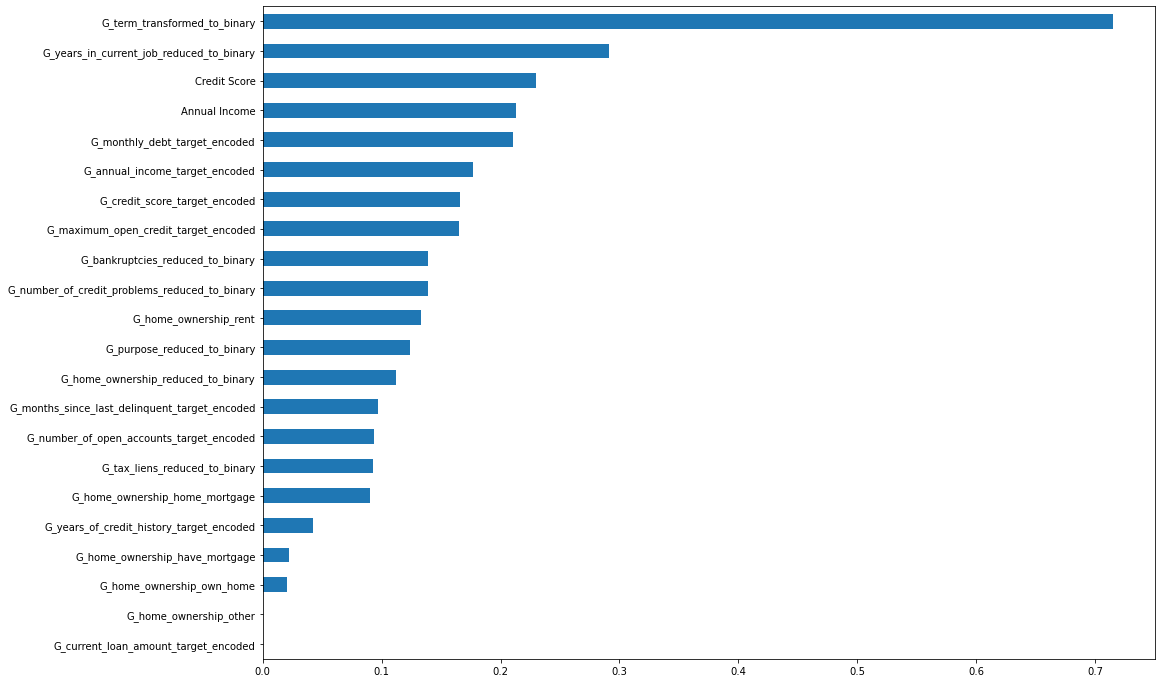

In [95]:
plt.figure(figsize = (16, 12))
features_coefficients.plot(kind="barh")

plt.show()

#### уберём из списка признаков признаки с коэффициентами равными 0

In [96]:
list_of_features = ['Annual Income',
                     'Credit Score',
                     'G_home_ownership_home_mortgage',
                     'G_home_ownership_rent',
                     'G_home_ownership_own_home',
                     'G_home_ownership_have_mortgage',
#                      'G_home_ownership_other',
                     'G_home_ownership_reduced_to_binary',
                     'G_years_in_current_job_reduced_to_binary',
                     'G_purpose_reduced_to_binary',
                     'G_term_transformed_to_binary',
                     'G_tax_liens_reduced_to_binary',
                     'G_number_of_credit_problems_reduced_to_binary',
                     'G_bankruptcies_reduced_to_binary',
                     'G_annual_income_target_encoded',
#                      'G_current_loan_amount_target_encoded',
                     'G_maximum_open_credit_target_encoded',
                     'G_number_of_open_accounts_target_encoded',
                     'G_years_of_credit_history_target_encoded',
                     'G_monthly_debt_target_encoded',
                     'G_months_since_last_delinquent_target_encoded',
                     'G_credit_score_target_encoded']

In [97]:
model = best_clf.best_estimator_

model.fit(X_balanced[list_of_features], y_balanced)
# model_1.fit(X_train_balanced, y_train_balanced)

check_metrics(model=model, probability_threshold=0.571, list_of_features=list_of_features)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3771
           1       0.55      0.53      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1616
           1       0.54      0.55      0.55       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1316  300
1                283  351


как видно, метрика на классе 1 немного увеличилась (probability_threshold также пришлось немного отрегулировать)

#### проверим, появились ли другие признаки с нулевыми коэффициентами

In [98]:
features_coefficients = pd.Series(model.coef_.tolist()[0], index=X_reduced[list_of_features].columns.tolist())
features_coefficients = abs(features_coefficients).sort_values()
print(features_coefficients)

G_home_ownership_have_mortgage                   0.028354
G_years_of_credit_history_target_encoded         0.049928
G_home_ownership_own_home                        0.051093
G_tax_liens_reduced_to_binary                    0.077338
G_months_since_last_delinquent_target_encoded    0.087815
G_number_of_open_accounts_target_encoded         0.090805
G_home_ownership_home_mortgage                   0.092502
G_purpose_reduced_to_binary                      0.099691
G_home_ownership_reduced_to_binary               0.115492
G_home_ownership_rent                            0.122996
G_number_of_credit_problems_reduced_to_binary    0.127431
G_bankruptcies_reduced_to_binary                 0.127431
G_maximum_open_credit_target_encoded             0.167049
G_annual_income_target_encoded                   0.168289
G_credit_score_target_encoded                    0.176065
G_monthly_debt_target_encoded                    0.224617
Annual Income                                    0.230585
Credit Score  

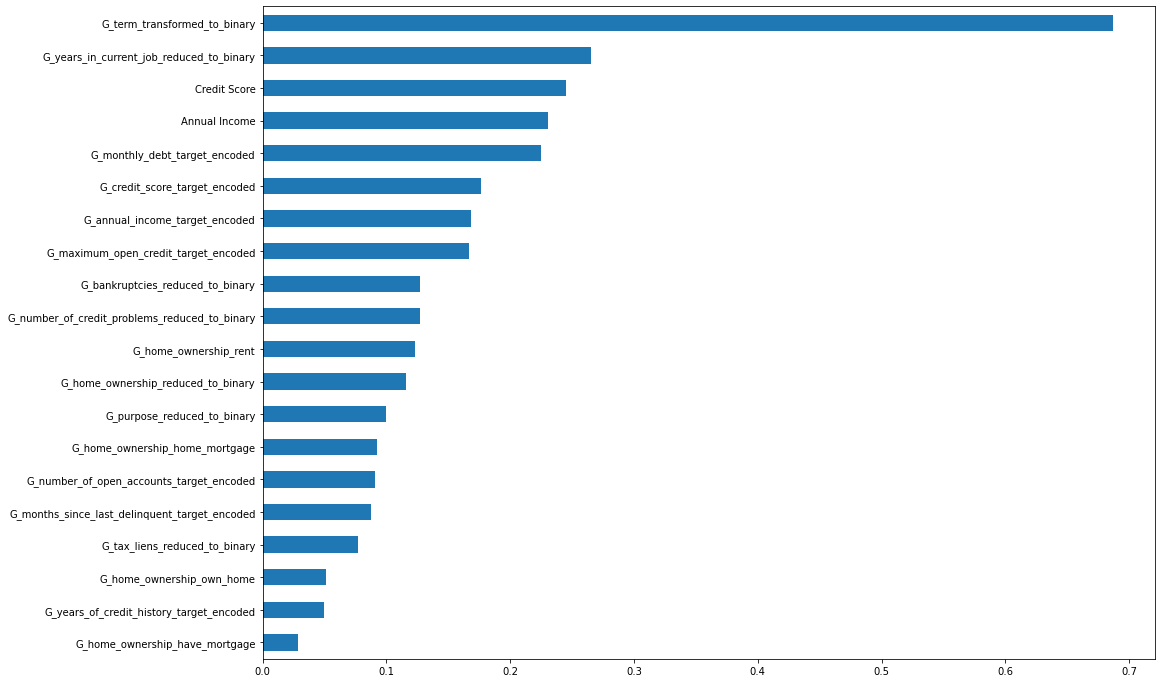

In [99]:
plt.figure(figsize = (16, 12))
features_coefficients.plot(kind="barh")

plt.show()

признаки с нулевыми коэффициентами не появились

## таким образом, оптимальной моделью в нашем случае является LogisticRegression(C=0.026366508987303583, solver='newton-cg'), а probability_threshold=0.571. Обучение модели должно проводиться на сбалансированном при помощи комбинации из TomekLinks и SMOTE датасете с убранными однозначно идентифицированными объектами

# создание классов предобработки и генерации признаков

# таргет энкодинг должен считать статистику на фите - сохранять словарь оригинального диапазона значений и присваемого, а на трансформе сопоставлять их

In [100]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [319]:
class DataPreprocessing:
    
    def __init__(self):
        self.target_name = 'Credit Default'
        
        self.annual_income_stat = None
        self.current_loan_amount_stat = None
        self.maximum_open_credit_stat = None
        self.number_of_open_accounts_stat = None
        self.years_of_credit_history_stat = None
        self.monthly_debt_stat = None
        self.months_since_last_delinquent_stat = None
        self.credit_score_stat = None
        
    def fit(self, X):
        self.annual_income_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Annual Income', self.target_name, False, True)
        self.current_loan_amount_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Current Loan Amount', self.target_name, False, False)
        self.maximum_open_credit_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Maximum Open Credit', self.target_name, True, True)
        self.number_of_open_accounts_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 5, 'Number of Open Accounts', self.target_name, False, True)
        self.years_of_credit_history_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Years of Credit History', self.target_name, False, False)
        self.monthly_debt_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Monthly Debt', self.target_name, False, False)
        self.months_since_last_delinquent_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Months since last delinquent', self.target_name, False, False)
        self.credit_score_stat = self.generate_target_encoded_feature_for_a_numerical_feature(
                                            X, 10, 'Credit Score', self.target_name, True, False)
        
        
    def transform(self, X):
        X = self.generate_dummies_from_home_ownership(X)
        X = self.generate_G_home_ownership_reduced_to_binary(X)
        X = self.generate_G_years_in_current_job_reduced_to_binary(X)
        X = self.generate_G_purpose_reduced_to_binary(X)
        X = self.generate_G_term_transformed_to_binary(X)
        X = self.generate_G_tax_liens_reduced_to_binary(X)
        X = self.generate_G_number_of_credit_problems_reduced_to_binary(X)
        X = self.generate_G_bankruptcies_reduced_to_binary(X)
        X = self.generate_G_annual_income_was_nan(X)
        
        return X
    
    def generate_dummies_from_home_ownership(self, X):
        X['G_home_ownership_home_mortgage'] = 0
        X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1

        X['G_home_ownership_rent'] = 0
        X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1

        X['G_home_ownership_own_home'] = 0
        X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1

        X['G_home_ownership_have_mortgage'] = 0
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1

        X['G_home_ownership_other'] = 0
        X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1

        return X
    
    def generate_G_home_ownership_reduced_to_binary(self, X):
        X['G_home_ownership_reduced_to_binary'] = 0
        X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
        return X
    
    def generate_G_years_in_current_job_reduced_to_binary(self, X):
        X['G_years_in_current_job_reduced_to_binary'] = 0
        X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
        return X
    
    def generate_G_purpose_reduced_to_binary(self, X):
        X['G_purpose_reduced_to_binary'] = 0
        X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
        return X
    
    def generate_G_term_transformed_to_binary(self, X):
        X['G_term_transformed_to_binary'] = 0
        X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
        return X
    
    def generate_G_tax_liens_reduced_to_binary(self, X):
        X['G_tax_liens_reduced_to_binary'] = 0
        X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
        return X
    
    def generate_G_number_of_credit_problems_reduced_to_binary(self, X):
        X['G_number_of_credit_problems_reduced_to_binary'] = 0
        X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
        return X
    
    def generate_G_bankruptcies_reduced_to_binary(self, X):
        X['G_bankruptcies_reduced_to_binary'] = 0
        X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
        return X
    
    def generate_G_annual_income_was_nan(self, X):
        X['G_annual_income_was_nan'] = 0
        X.loc[X['Annual Income'].isna(), 'G_annual_income_was_nan'] = 1  
        return X
    
    def generate_target_encoded_feature_for_a_numerical_feature(self, X, number_of_categories, 
                                                                feature_name, target_name, 
                                                                push_right_min_outliers_in_feature_name, 
                                                                push_left_max_outliers_in_feature_name):
        # функция генерирует новый признак
        # путём разбиения пространства оригинального признака на заданное количество равных интервалов
        # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
        # к общему числу объектов на каждом интервале
        # с присвоением значения вероятности какждому объекту в виде значения нового признака.
        # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
        # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
        # при генерации нового признака используя действительную функцию
        # следует проверить целесообразность такого действия 
        # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
        # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
        # значения равные 2.5% от минимума и 2.5% от максимума соответственно.

#         X = df.copy()

        # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
        # значений равных 2.5% от минимума и 2.5% от максимума соответственно
        value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
        value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)

        if push_right_min_outliers_in_feature_name:
            X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025

        if push_left_max_outliers_in_feature_name:
            X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975

        # выявление минимального и максимального значений на пространстве значений исходного признака
        feature_min_value = X[feature_name].min()
        feature_max_value = X[feature_name].max()

        # создание интервалов из пространства значений исходного признака
        limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
        limits_of_categories = [round(i, 3) for i in limits_of_categories.tolist()]

        # генерация имени нового признака
        new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'

        # заполнение нового признака средним значением целевой переменной -
        # перестраховка, чтобы избежать возможности пропусков
        X[new_feature_name] = X[target_name].mean()

        # заполнение пропусков в признаке средним значением целевой переменной на объектах,
        # где есть пропуски в признаках
        X.loc[X[feature_name].isna(), new_feature_name] = X.loc[X[feature_name].isna(), target_name].mean()

        # присвоение каждому объекту значения нового признака равного вероятности 
        # появления значения целевой переменной == 1 на заданном интервале оригинального признака
        
        
        # добавление target encoded значений, где у оригинальной переменной был NaN
        
        nan_category_stat = None
        try:
            nan_category_stat = X.loc[X[feature_name].isna()][target_name].value_counts()
            nan_category_stat = round((nan_category_stat[1] / sum(nan_category_stat)), 3)
#             nan_category_stat.append(category_stat_)
        except:
            None
        
        category_stat = []
        i = 0
        while True:
            if i == number_of_categories:
                break

            try:
                category_stat_ =\
                    X.loc[(X[feature_name] >= limits_of_categories[i]) & 
                          (X[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
                
                category_stat_ = round((category_stat_[1] / sum(category_stat_)), 3)
                
                
                category_stat.append(category_stat_)
                
                
                
                # category_stat это количество объектов обоих классов на выбранном отрезке признака

#                 X.loc[(X[feature_name] >= limits_of_categories[i]) & 
#                       (X[feature_name] < limits_of_categories[i + 1]), 
#                       new_feature_name] = round((category_stat[1] / sum(category_stat)), 3)
                

            except:
                category_stat.append(None)
#                 None
            print(f'{new_feature_name} | {i} | {category_stat_}')

            i += 1
            
        return {'new_feature_name': new_feature_name,
                'limits_of_categories': limits_of_categories, 
                'category_stat': category_stat, 
                'nan_category_stat': nan_category_stat}

In [320]:
len({}) 

0

In [321]:
[np.nan] + [1]

[nan, 1]

In [322]:
a = pd.DataFrame({
    'e': [1, 2, 3],
    'r': [4, 5, 6]
})
def aaa(a):
    a.loc[a['e'] < 3, 'e'] = 3
    print(a['e'])

aaa(a)

0    3
1    3
2    3
Name: e, dtype: int64


In [323]:
X = train_df.copy()
X.shape

(7500, 17)

In [324]:
sample_of_dp = DataPreprocessing()
# X = sample_of_dp.fit(X)
sample_of_dp.fit(X)
# X = sample_of_dp.transform(X)
# X.shape

G_annual_income_target_encoded | 0 | 0.336
G_annual_income_target_encoded | 1 | 0.333
G_annual_income_target_encoded | 2 | 0.292
G_annual_income_target_encoded | 3 | 0.252
G_annual_income_target_encoded | 4 | 0.23
G_annual_income_target_encoded | 5 | 0.219
G_annual_income_target_encoded | 6 | 0.207
G_annual_income_target_encoded | 7 | 0.138
G_annual_income_target_encoded | 8 | 0.191
G_annual_income_target_encoded | 9 | 0.156
G_current_loan_amount_target_encoded | 0 | 0.319
G_current_loan_amount_target_encoded | 1 | Series([], Name: Credit Default, dtype: int64)
G_current_loan_amount_target_encoded | 2 | Series([], Name: Credit Default, dtype: int64)
G_current_loan_amount_target_encoded | 3 | Series([], Name: Credit Default, dtype: int64)
G_current_loan_amount_target_encoded | 4 | Series([], Name: Credit Default, dtype: int64)
G_current_loan_amount_target_encoded | 5 | Series([], Name: Credit Default, dtype: int64)
G_current_loan_amount_target_encoded | 6 | Series([], Name: Credit Defau

In [308]:
X.shape

(7500, 25)

In [311]:
sample_of_dp.annual_income_stat

{'new_feature_name': 'G_annual_income_target_encoded',
 'limits_of_categories': [164597.0,
  492558.66,
  820520.32,
  1148481.98,
  1476443.64,
  1804405.3,
  2132366.96,
  2460328.62,
  2788290.28,
  3116251.94,
  3444213.6],
 'category_stat': [0.336,
  0.333,
  0.292,
  0.252,
  0.23,
  0.219,
  0.207,
  0.138,
  0.191,
  0.156],
 'nan_category_stat': 0.34}

In [312]:
print('\n' + 'annual_income_stat')
print('limits_of_categories:', len(sample_of_dp.annual_income_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.annual_income_stat['category_stat']))

print('\n' + 'current_loan_amount_stat')
print('limits_of_categories:', len(sample_of_dp.current_loan_amount_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.current_loan_amount_stat['category_stat']))

print('\n' + 'maximum_open_credit_stat')
print('limits_of_categories:', len(sample_of_dp.maximum_open_credit_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.maximum_open_credit_stat['category_stat']))

print('\n' + 'number_of_open_accounts_stat')
print('limits_of_categories:', len(sample_of_dp.number_of_open_accounts_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.number_of_open_accounts_stat['category_stat']))

print('\n' + 'years_of_credit_history_stat')
print('limits_of_categories:', len(sample_of_dp.years_of_credit_history_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.years_of_credit_history_stat['category_stat']))

print('\n' + 'monthly_debt_stat')
print('limits_of_categories:', len(sample_of_dp.monthly_debt_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.monthly_debt_stat['category_stat']))

print('\n' + 'months_since_last_delinquent_stat')
print('limits_of_categories:', len(sample_of_dp.months_since_last_delinquent_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.months_since_last_delinquent_stat['category_stat']))

print('\n' + 'credit_score_stat')
print('limits_of_categories:', len(sample_of_dp.credit_score_stat['limits_of_categories']))
print('category_stat:', len(sample_of_dp.credit_score_stat['category_stat']))


annual_income_stat
limits_of_categories: 11
category_stat: 10

current_loan_amount_stat
limits_of_categories: 11
category_stat: 1

maximum_open_credit_stat
limits_of_categories: 11
category_stat: 10

number_of_open_accounts_stat
limits_of_categories: 6
category_stat: 5

years_of_credit_history_stat
limits_of_categories: 11
category_stat: 9

monthly_debt_stat
limits_of_categories: 11
category_stat: 8

months_since_last_delinquent_stat
limits_of_categories: 11
category_stat: 8

credit_score_stat
limits_of_categories: 11
category_stat: 4


In [ ]:
        self.annual_income_stat = None
        self.current_loan_amount_stat = None
        self.maximum_open_credit_stat = None
        self.number_of_open_accounts_stat = None
        self.years_of_credit_history_stat = None
        self.monthly_debt_stat = None
        self.months_since_last_delinquent_stat = None
        self.credit_score_stat = None

In [202]:
X.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64